# Reproduce some important results from our paper "Greed Meets Sparsity..."

### The results in this notebook maybe a little bit different from the paper due to the random number generation

In [1]:
import numpy as np
import random
from sklearn.datasets.samples_generator import make_regression
from sklearn.preprocessing import normalize
from numpy.linalg import norm
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import matplotlib
from lasso import lasso_gcd
# from lasso import elastic_net_gcd
# from lasso import lasso_omp
# from generate_plot import *

In [2]:
random.seed(123)
n = 50
m = 10000
k = 10
e = 0.1
#A = np.zeros( (n, m) )
A = np.random.randn( n, m )
xx = np.zeros( m )
xx[ np.random.permutation(m)[:k] ] = np.random.randn(k)
b = np.dot(A, xx) + e*np.random.randn(n)

In [3]:
A = normalize(A.T).T
X = A
y = b

Use the package sklearn to get optimum

In [4]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=2.0/50, fit_intercept=False, max_iter=10000, tol=1e-14, selection='cyclic')
model.fit(X, y)
sum(model.coef_ != 0)

29

### Optimize the problem with GCD, run only 50 iterations for the initial investigation

In [5]:
model1 = lasso_gcd(maxiter=50, lamb = 2.0, L = 1, delta=1.0, verbose = True, interval = 1)
model1.fit(A, b, model.coef_)

optimization finished!


### Reproduce Figure 1 (a)

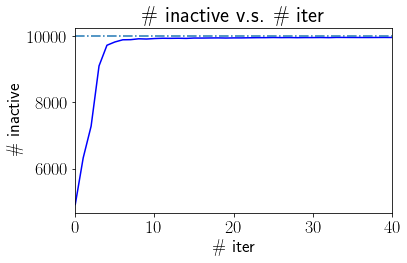

In [6]:
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
plt.rc('text', usetex=True)

#plt.plot( model1.n_inactive )
plt.plot( model1.n_inactive_grad, 'b-' )
plt.plot( 10000*np.ones( len(model1.n_inactive_grad) ), '-.' )
plt.xlim([0, 40])
plt.xlabel('\# iter')
plt.ylabel('\# inactive')
plt.title('\# inactive v.s. \# iter')
plt.tight_layout()
#plt.savefig('pic/inactive_plot_large.png', dpi=300)
plt.show()

In [7]:
exact_obj = 0.5*norm( A.dot( model.coef_ ) - b ,2 )**2 + 2.0*norm( model.coef_ ,1)
exact_obj
obj_list = model1.obj_list
obj_gap = obj_list - exact_obj
progress = 1 - obj_gap[1:]/obj_gap[:-1]

### Reproduce Figure 1 (b)

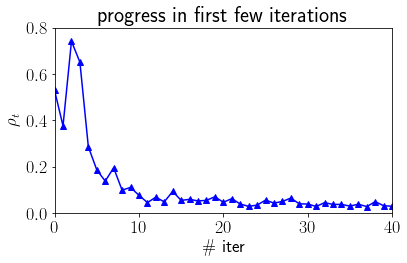

In [8]:
plt.rc('text', usetex=True)
plt.plot( progress, 'b-^' )
plt.xlim([0, 40])
plt.ylim( [0, 0.8] )
plt.xlabel('\# iter')
plt.ylabel(r'$\rho_t$', fontsize=17)
plt.title('progress in first few iterations')
plt.tight_layout()
#plt.savefig('pic/beginning_progress_large.png', dpi=300)
plt.show()

### Reproduce Figure 2 (a)

In [9]:
def approx_mu1( A, sol, add_num, num_trails ):
    nnz_pattern = [i for i in range(len(xx)) if xx[i] != 0 ]
    for j in range(add_num):
        while(True):
            idx = np.random.randint( len(xx) )
            if idx in nnz_pattern:
                continue
            else:
                nnz_pattern.append( idx )
                break
    A_sub = A[:,nnz_pattern]
    nnz = len(nnz_pattern)
    res = []
    for j in range( num_trails ):
        x = np.random.randn( nnz )
        mu_1 = norm( np.dot(A_sub, x), 2 )**2 / norm(x, 1)**2
        res.append( mu_1 )
    return res

def approx_mu1_global( A, num_trails ):
    res = []
    for j in range( num_trails ):
        nnz = A.shape[1]
        x = np.random.randn( nnz )
        mu_1 = norm( np.dot(A, x), 2 )**2 / norm(x, 1)**2
        res.append( mu_1 )
    return res

In [10]:
n_trails = 1000
mu_1_list = []
t = 30
for i in range( t ):
    mu_1_list.append(  np.min(  approx_mu1(A, model.coef_, i, n_trails)  )  )

global_mu1 = np.min( approx_mu1_global( A, 1000 ) )

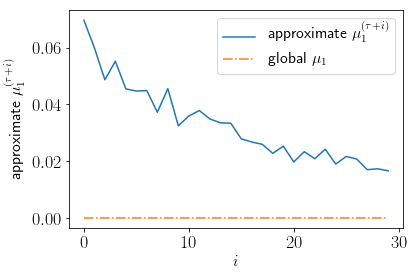

In [11]:
matplotlib.rcParams.update({'font.size': 16})
plt.rc('text', usetex=True)

it = np.linspace( 0, 29, 30 )
plt.plot( it, mu_1_list, label=r"approximate $  \mu_1^{( \tau + i ) }$" )
plt.plot( it, global_mu1*np.ones(len(it)), '-.' , label=r"global $\mu_1$")
plt.legend()
plt.ylabel(r"approximate $  \mu_1^{( \tau + i ) }$")
plt.xlabel(r"$i$")
plt.show()
#plt.tight_layout()
#plt.savefig("pic/mu_1_plot.png", dpi=300)

### Run GCD for 10000 iterations, this step is time consuming

In [12]:
model1 = lasso_gcd(maxiter=10000, lamb = 2.0, L = 1, delta=1.0, verbose = True, interval = 10)
model1.fit(A, b, model.coef_)

optimization finished!


### Reproduce Figure 2 (b)

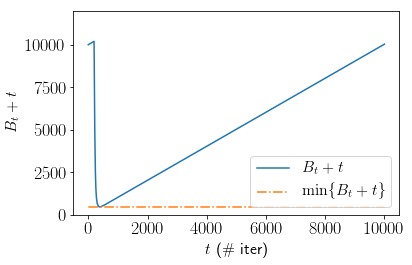

In [13]:
plt.plot(model1.bound[:], label=r"$B_t + t$")
plt.plot( np.min(model1.bound)*np.ones( len(model1.bound) ), '-.', label=r" $\min\{B_t + t\}$ " )
plt.legend()
plt.ylim(0, 12000)
plt.xlabel(r"$t$ (\# iter)")
plt.ylabel(r"$B_t + t$")
plt.tight_layout()
#plt.savefig("pic/Wbound_realdata.png", dpi=300)
plt.show()

In [14]:
import pandas as pd
df=pd.read_csv('../datasets/leukemia_big.csv', sep=',',header=0)

In [15]:
hd = list(df)
y = [ float( 'ALL' in res ) for res in hd ]
y = np.array( y )
print( y.shape )
X = df.values
X = X.T
print( X.shape )
X = normalize(X.T).T

(72,)
(72, 7128)


### Run $\Delta$-GCD for a LASSO problem with the dataset leukemia.

In [16]:
model1 = lasso_gcd(maxiter=int(1e4), lamb = 1e-1, delta=np.sqrt(1.0), verbose = True)
model1.fit(X, y)
model2 = lasso_gcd(maxiter=int(1e4), lamb = 1e-1, delta=np.sqrt(0.5), verbose = True)
model2.fit(X, y)
model3 = lasso_gcd(maxiter=int(1e4), lamb = 1e-1, delta=np.sqrt(0.1), verbose = True)
model3.fit(X, y)

optimization finished!
optimization finished!
optimization finished!


In [18]:
# get exact optimal value
from sklearn.linear_model import Lasso
model = Lasso(alpha=1e-1/72.0, fit_intercept=False, max_iter=10000, tol=1e-14, selection='cyclic')
model.fit(X, y)

Lasso(alpha=0.001388888888888889, copy_X=True, fit_intercept=False,
   max_iter=10000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=1e-14, warm_start=False)

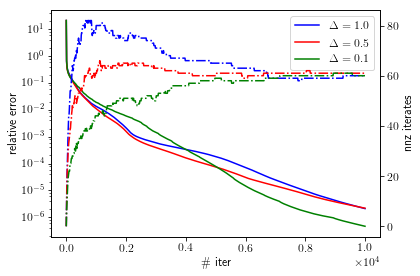

In [21]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

xx = model.coef_
exact_obj = 0.5*np.linalg.norm( np.dot(X, xx) - y, 2 )**2 + 1e-1*np.linalg.norm( xx, 1 ) 
obj1 = model1.obj_list
obj2 = model2.obj_list
obj3 = model3.obj_list
rel_error1 = (obj1 - exact_obj) / exact_obj
rel_error2 = (obj2 - exact_obj) / exact_obj
rel_error3 = (obj3 - exact_obj) / exact_obj
it = np.linspace( 0, 10000, 1000 )
#print(obj1[-1])


fig, ax1 = plt.subplots()

ax1.semilogy(it, rel_error1, 'b-', label = r"$\Delta = 1.0$")
ax1.semilogy(it, rel_error2, 'r-', label = r"$\Delta = 0.5$")
ax1.semilogy(it, rel_error3, 'g-', label = r"$\Delta = 0.1$")
#ax1.set_ylim([1e-3, 1e1])
plt.legend()

# ax1.set_xlabel('time (s)')
# # Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('relative error')
ax1.set_xlabel(r'\# iter')

#ax1.tick_params('relative error')


ax2 = ax1.twinx()
ax2.plot(it, model1.nnz_sol, 'b-.')
ax2.plot(it, model2.nnz_sol, 'r-.')
ax2.plot(it, model3.nnz_sol, 'g-.')


ax2.set_ylabel('nnz iterates')
ax2.tick_params('nnz iterates')

plt.ticklabel_format(style='sci', axis='x', scilimits=(1,4))

plt.tight_layout()
plt.show()
#plt.savefig("pic/leuk_lasso_1e-2.png", dpi=300)
